In [1]:
%matplotlib notebook

In [2]:
import pyspark

sc = pyspark.sql.SparkSession.Builder().getOrCreate()

## Levanto los archivos

In [3]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold 
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.neighbors import base
from IPython.display import display, HTML
import math
import time
import matplotlib.animation as animation

from utils.emissions_normalizer import EmissionsNormalizer
from utils.knn_predictor import KnnPredictor
from utils.smoother import Smoother
from utils.random_predictor import RandomPredictor


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


## Map utils

In [4]:
global posicion_antenas
posicion_antenas = [(463512.015195402,6111004.324434620),(464259.981343845,6110331.85100085),(464443.295130103,6111377.26171875),(464629.562194595,6111105.34734669)]
nombre_antenas = ["RC1", "RC2", "D1", "D2"] 


global x_0
global y_0

x_0 = 462385.503783397
x_f = 465958.114906211
y_0 = 6109042.35153865
y_f = 6112715.80637111



## Entreno el modelo que vamos a usar para predecir

In [5]:
points_recep = sc.read.json('datos/train-test-by-emission.jsonlines/').rdd

In [6]:
normalizer = EmissionsNormalizer()
data = normalizer.normalize(points_recep)
regre_data, regre_target = normalizer.get_regression_dataframes(data)

In [7]:
predictor = KnnPredictor()
predictor.fit(regre_data, regre_target)

In [8]:
random_predictor = RandomPredictor()
random_predictor.fit(regre_data, regre_target)

## Levanto el archivo con las emisiones de los pajaros

In [9]:
#birds_recep = sc.read.json('datos/day-birds.jsonlines/').rdd
birds_recep = sc.read.json('datos/all-birds-data.jsonlines/').rdd
#birds_recep = birds_recep.sortBy(lambda x: x['timestamp'])

# Error analysis

### Mapa con el movimiento predicho para un pajaro

In [10]:
def update_animation(data, p):
    x = data[0]
    y = data[1]
    p.set_data(x, y)
    plt.title(data[7])
    return p
 

def show_birds_movement(predictions, delay=200):
    fig, ax = plt.subplots()
    point, = ax.plot([0], [0], 'go', color='red')
    point.set_data(0, 0)
    plt.ylim(0,y_f-y_0)
    plt.xlim(0,x_f-x_0)
    all_points_pos = pd.DataFrame(points_recep.map(lambda p: {'x': p['x'], 'y': p['y']}).map(normalize_positions).collect())
    plt.scatter(all_points_pos['x'], all_points_pos['y'], c='#96EAE1', s=10)
    for antenna in range(4):
            pos_antena = posicion_antenas[antenna]
            plt.plot(pos_antena[0]-x_0, pos_antena[1]-y_0, "dy")
    ani = animation.FuncAnimation(fig, update_animation, predictions, interval=delay, fargs=(point,))


In [14]:
BIRD_TAG_ID = 20
START_TIME = '2018-01-10 09:00:00'
END_TIME = '2018-01-10 17:00:00'

single_bird = (
    birds_recep
    .filter(lambda x: x['tag_id'] == BIRD_TAG_ID)
    .filter(lambda x: x['timestamp'] >= START_TIME and x['timestamp'] < END_TIME)
    .sortBy(lambda x: x['timestamp'])
)

birds_data = pd.DataFrame(single_bird.collect()).drop(columns=[4,5])

In [15]:
predictions = predictor.predict(birds_data)
predictions = pd.concat([pd.DataFrame(predictions), pd.DataFrame(single_bird.collect())], axis=1).values

In [29]:
from utils.smoother import Smoother

smoother = Smoother(window_threshold=300, step_size=0)
smooth_predictions_np = smoother.smooth_predictions(predictions)
#smooth_predictions_np = predictions
#smooth_predictions_np = smoother.filter_predictions(predictions)

In [31]:
len(predictions)

2052

In [30]:
len(smooth_predictions_np)

2052

<IPython.core.display.Javascript object>


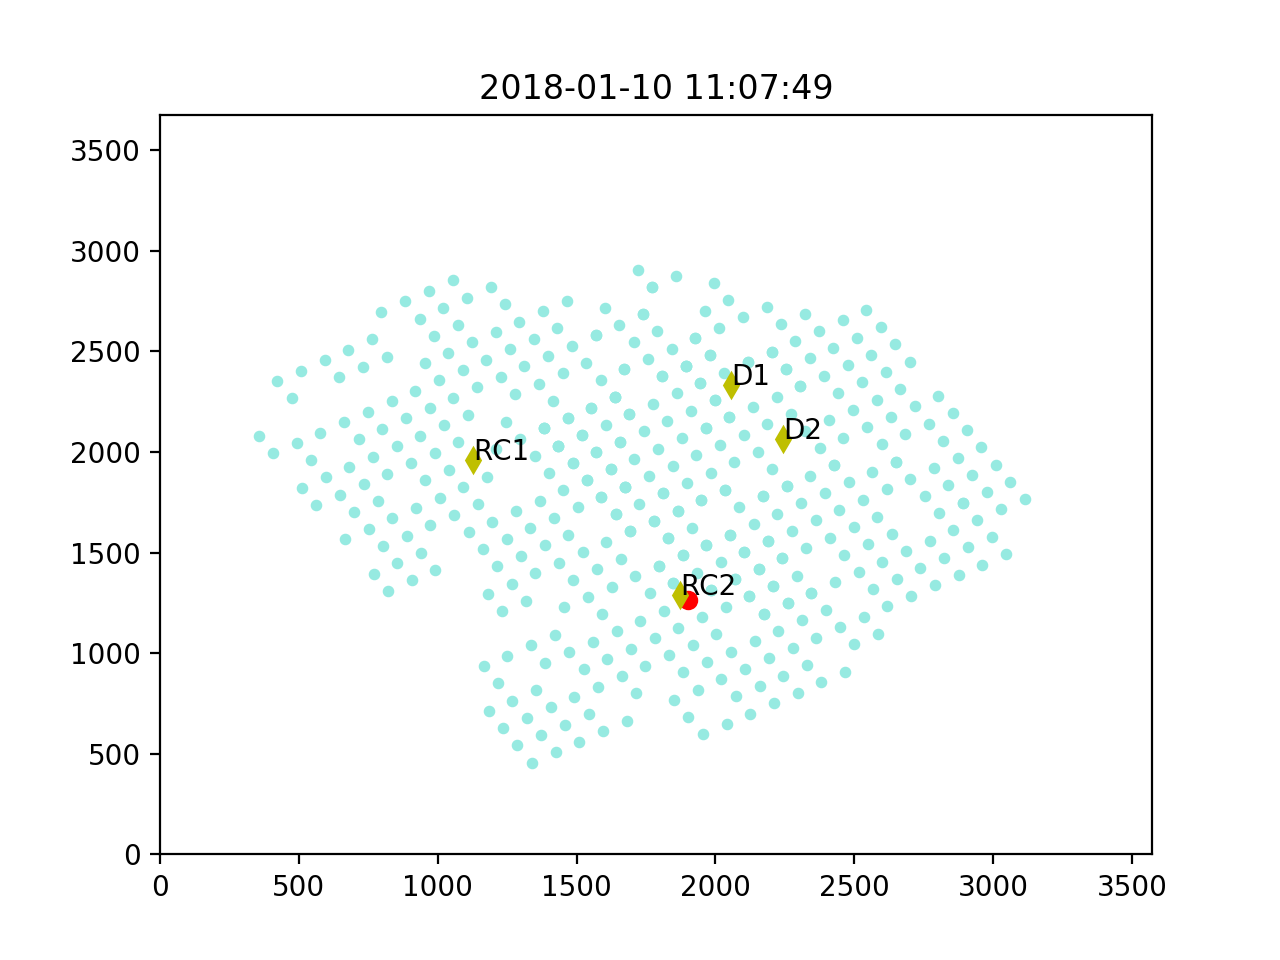

In [39]:
DELAY = 30
#show_birds_movement(predictions)

fig, ax = plt.subplots()
point, = ax.plot([0], [0], 'go', color='red')
point.set_data(0, 0)
plt.ylim(0,y_f-y_0)
plt.xlim(0,x_f-x_0)
all_points_pos = pd.DataFrame(points_recep.map(lambda p: {'x': p['x'], 'y': p['y']}).map(normalizer._normalize_positions).collect())
plt.scatter(all_points_pos['x'], all_points_pos['y'], c='#96EAE1', s=10)
for antenna in range(4):
        pos_antena = posicion_antenas[antenna]
        plt.plot(pos_antena[0]-x_0, pos_antena[1]-y_0, "dy")
        name = nombre_antenas[antenna]
        ax.annotate(name, xy=(pos_antena[0]-x_0, pos_antena[1]-y_0), textcoords='data') 
        
ani = animation.FuncAnimation(fig, update_animation, smooth_predictions_np, interval=DELAY, fargs=(point,), repeat=False)

